# Topic modeling example

This exercise introduces topic modeling using the LDA (Latent Dirichlet Allocation) algorithm and the Non-negative Matrix Factorisation (NMF) algorithm.

Topic modeling is an unsupervised approach that allows you to explore large text collections.

In this example, we use the gensim LDA and pyLDAvis implementations for one type of analysis, as well as the sklearn implementations of LDA and NMF to look at how the models relate to categories in the data. 

The main packages that are used in this example are:

nltk: http://www.nltk.org/ - for preprocessing

gensim: https://radimrehurek.com/gensim/ - for building the LDA model

pyLDAvis: https://github.com/bmabey/pyLDAvis - for visualization and easier exploration of the generated topics

sklearn: https://scikit-learn.org/stable/, https://scikit-learn.org/stable/modules/decomposition.html#nmf - for building LDA and NMF models

The example is inspired by, and uses functions from: http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/Gensim%20Newsgroup.ipynb
and
https://github.com/derekgreene/topic-model-tutorial/blob/master/2%20-%20NMF%20Topic%20Models.ipynb

Written by: Sumithra Velupillai, with input from Sonia Priou, February 2019 

In [1]:
## First we need to import all the necessary packages

import string
from gensim import models
from gensim.corpora import Dictionary, MmCorpus
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import itertools
import zipfile

try:
    import pyLDAvis
except ImportError as e:
    !pip install pyldavis
    import pyLDAvis

import pyLDAvis.gensim as gensimvis
import os
import pandas as pd

import re
import codecs
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

import numpy as np
from sklearn.decomposition import NMF, LatentDirichletAllocation
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings; warnings.simplefilter('ignore')



[nltk_data] Downloading package punkt to /Users/sumithra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sumithra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/sumithra/anaconda3/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


# 1: corpus
The first step in building a topic model is to read a corpus, or a collection of documents.

In this example, we are using documents from http://www.mtsamples.com/. 

These are transcribed medical transcriptions sample reports and examples from a variety of clinical disciplines, such as radiology, surgery, discharge summaries. Note that one document can belong to several categories. 

We will save each document, all its words, and which clinical specialty it belongs to, in a dataframe.


In [2]:
xlds = 'https://github.com/KCL-Health-NLP/nlp_examples/blob/master/topic_modelling/mtsamples_for_topic_modelling.xlsx?raw=true'
df = pd.read_excel(xlds)

How many documents are in the data?

In [3]:
len(df)

6385

How many clinical specialties are in the data? 

In [4]:
df['Category'].value_counts()

85-surgery                   1103
97-consult                    516
97-consult-historyandphy.     516
6-cardiovascularpulmonary     372
49-orthopedic                 355
95-radiology                  273
98-general                    259
98-generalmedicine            259
24-gastroenterology           230
42-neurology                  223
91-soapchartprogressnotes     166
45-obstetricsgynecology       160
82-urology                    158
89-discharge                  108
89-dischargesummary           108
100-ent                        98
100-ent-otolaryngology         98
43-neurosurgery                94
96-hematology                  90
96-hematology-oncology         90
46-ophthalmology               83
41-nephrology                  81
93-emergencyroomreports        75
93-emergency                   75
66-pediatrics-neonatal         70
66-pediatrics                  70
105-pain                       62
105-painmanagement             62
72-psychiatrypsychology        53
87-officenotes

We need to convert the texts to words - let's use a very simple approach

In [5]:
def getWords(row):
    
    return [''.join(c.lower() for c in s if c not in string.punctuation) for s in nltk.word_tokenize(row)]

df['Document words'] = df['Document Content'].apply(getWords)


# 2 Using gensim and pyLDAVis

We now need to generate representations for the vocabulary (dictionary) and the text collection (corpus)

Let's use some functions that we can call later, and that we can modify later if we want.

(Using all the words in the whole corpus or text collection is not typically what you want, because very common words, 

or very rare words will not generate good topic representations. Why?

What parameters and configurations could be interesting to change below?)

In [ ]:

## functions from http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/Gensim%20Newsgroup.ipynb

## this function returns a set of stopwords predefined in the nltk package

def nltk_stopwords():
    return set(nltk.corpus.stopwords.words('english'))

## this function prepares the data and returns a dictionary and a corpus.
## which parameters do you think would be worth modifying/experimenting with?

def prep_corpus(docs, additional_stopwords=set(), no_below=5, no_above=0.5):
  print('Building dictionary...')
  dictionary = Dictionary(docs)
  stopwords = nltk_stopwords().union(additional_stopwords)
  stopword_ids = map(dictionary.token2id.get, stopwords)
  dictionary.filter_tokens(stopword_ids)
  dictionary.compactify()
  dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=None)
  dictionary.compactify()

  print('Building corpus...')
  corpus = [dictionary.doc2bow(doc) for doc in docs]

  return dictionary, corpus




In [ ]:
## now, let's use the functions we defined above to get our dictionary and corpus
dictionary, corpus = prep_corpus(df['Document words'])

In [ ]:
## If you want, you can save your corpus and dictionary to disk for quicker processing later

#MmCorpus.serialize('/Users/sumithra/DSV/MeDESTO/teaching/Farr2017/data/gensim_topic_model_data/mtsamples.mm', corpus)
#dictionary.save('/Users/sumithra/DSV/MeDESTO/teaching/Farr2017/data/gensim_topic_model_data/mtsamples.dict')

In [ ]:
## Now we have our dictionary and corpus, let's generate an LDA model.
## The LDA model has many parameters that can be set, all available parameters can be found here:
## https://radimrehurek.com/gensim/models/ldamodel.html

## Here, we've set the number of topics to 10.

lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=10)

## You can also save the generated model to disk if you want
#lda.save('/Users/sumithra/DSV/MeDESTO/teaching/Farr2017/data/gensim_topic_model_data/mtsamples_20_lda.model')

In [ ]:
## you can now look at these topics by printing them from the generated model

lda.print_topics()

In [ ]:

## It can be hard to get a good understanding of what's actually in these topics
## Visualizations are very helpful for this, let's use a package that does this:

vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

Take a look at the results. What observations do you have? What happens if you change the number of topics?

# 3 Using sklearn and comparing with 'existing' categories

Now you have seen how you can build a topic models with gensim and look at the contents visually with pyLDAVis.

You can also use sklearn for topic modeling, both lda and nmf, and analyse results visually by comparing with existing categories, if you have them.

NMF approaches can be very efficient, particularly with smaller datasets. Let's see what you think.



In [6]:
# We need a couple of functions to visualise the data
# Preparation for visualisation 
# Written by Sonia Priou, adaptations by Sumithra Velupillai

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

def get_topic_list(model, feature_names, no_top_words):
    tlist = {}
    for topic_idx, topic in enumerate(model.components_):
        tlist[topic_idx]= str("%d: " % (topic_idx)+", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    return tlist

    
def display_topic_representation (model,dataframe,tlist):
    doc_topic = model    #example : model = lda_Tfidf.transform(tfidf)
    doc = np.arange(doc_topic.shape[0])
    num_topics = doc_topic.shape[1]
    dico = {'index': doc}
    for n in range(num_topics):
        dico["topic" + str(n)] = doc_topic[:,n]
    
    #Max topic 
    Topic_max = []
    for i in range(doc_topic.shape[0]):
        if len(set(doc_topic[i])) == 1:
            Topic_max.append(num_topics+1)
        else:
            Topic_max.append(doc_topic[i].argmax())
    dico["Topic most represented"] = Topic_max
    #print(Topic_max)
    tlist[num_topics+1] = 'NONE'
    dico["Topic and its most representative words"] = [tlist[x] for x in Topic_max]
    df_topic = pd.DataFrame(dico)

    
    #Link both DataFrame
    df_result = pd.merge(dataframe,df_topic, on='index')
    df_result = df_result.sort_values('Topic most represented')
    
    #Finding within the cluster found by LDA the original file
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    sns.set_style('whitegrid')
    sns.countplot(y='Topic and its most representative words', data = df_result)
    return df_result

def display_file_representation (model,dataframe):
    #Within a file, what is the slipt between topics found
    doc_topic = model    #example : model = lda_Tfidf.transform(tfidf)
    doc = np.arange(doc_topic.shape[0])
    no_topics = doc_topic.shape[1]
    topic = np.arange(no_topics)
    dico = {'index': doc}
    for n in range(no_topics):
        dico["topic" + str(n)] = doc_topic[:,n]
    #Max topic 
    Topic_max = []
    for i in range(doc_topic.shape[0]):
        Topic_max.append(doc_topic[i].argmax())
    dico["Topic most represented"] = Topic_max
    df_topic = pd.DataFrame(dico)
    #print(df_topic)
    
    
    #Link both DataFrame
    df_result = pd.merge(dataframe,df_topic, on='index')
    
    dico2 = {'Topic': topic}
    for i in df_result['Category'].value_counts().index:
        ser = df_result.loc[df_result['Category']==i].mean()
        score = ser[2:no_topics+2]
        dico2[i]=score

    df_score = pd.DataFrame(dico2)
    print('For each given file, we calculate the mean percentage of the documents depence to each topic')
    print('')
    print(df_score)
    print(df_result['Category'].value_counts().index)

    fig, axs = plt.subplots(ncols=len(dataframe['Category'].value_counts()))
    count = 0
    for i in df_result['Category'].value_counts().index:
        sns.barplot(x='Topic', y =i ,data = df_score, ax=axs[count])
        count = count + 1
        
    plt.tight_layout()

Let's look at a smaller sample, to make the analysis a bit easier. You can choose other categories of course!

In [7]:
categories_to_keep = ['17-dentistry', '46-ophthalmology', '72-psychiatrypsychology', '71-podiatry']
df_smaller = df.loc[df['Category'].isin(categories_to_keep)]
#new_df = df.drop(df_smaller)
new_df = df[~df.isin(df_smaller)]
df_smaller['index'] = range(0,len (df_smaller))
df_smaller.head()

,Unnamed: 0,index,Category,Document Name,Document Content,Document words
475,475,0,17-dentistry,2336-bonyimpactedteethremoval.txt,PREOPERATIVE D...,"[preoperative, diagnosis, , completely, bony, ..."
476,476,1,17-dentistry,1260-dentalpain-emergencyvisit.txt,CHIEF COMPLAIN...,"[chief, complaint, , dental, painhistory, of, ..."
477,477,2,17-dentistry,2748-jawpain-ervisit.txt,CHIEF COMPLAIN...,"[chief, complaint, , jaw, painhistory, of, pre..."
478,478,3,17-dentistry,1916-odontogenicabscessid.txt,PREOPERATIVE D...,"[preoperative, diagnoses1, , left, facial, cel..."
479,479,4,17-dentistry,2338-teethextractionid.txt,PREOPERATIVE D...,"[preoperative, diagnoses1, , carious, teeth, ,..."


Now let's use sklearn's function for converting corpora to document-term-matrices. We'll define a function for this, which takes as parameters a dataframe, the name of the text column that should be transformed to tf-idf, and some optional parameters for thresholds in creating the model. These thresholds can of course be changed!

In [8]:
def get_tfidf_model(dataframe, text_column, min_df = 5, max_df=100000, lowercase = True):
    stopwords = nltk.corpus.stopwords.words('english')
    min_df = 5
    max_df = 100000
    lowercase = True
    

    bow_transformer = CountVectorizer(stop_words=stopwords, 
                                  min_df=min_df, 
                                  max_df=max_df, 
                                  lowercase = lowercase).fit(dataframe[text_column])
    document_bow = bow_transformer.transform(dataframe[text_column])
    feature_names = bow_transformer.get_feature_names()

    tfidf_transformer = TfidfTransformer().fit(document_bow)
    document_tfidf= tfidf_transformer.transform(document_bow)
    return feature_names, document_tfidf

Let's also define some functions to train the different topic models - we're using NMF and LDA with some preset parameters, these can of course be changed. Note that the two functions return different variables.

In [9]:
def getNMFModel(no_topics, document_tfidf):
    nmf = NMF(n_components=no_topics, 
          random_state=1, 
          alpha=.1, 
          l1_ratio=.5, 
          init='nndsvd').fit(document_tfidf)

    W = nmf.transform(document_tfidf)
    H = nmf.components_
    return nmf, W, H

def getLDAModel(no_topics, document_tfidf):
    lda = LatentDirichletAllocation(n_components=no_topics).fit(document_tfidf)
    return lda

Now let's convert our data to a tfidf model and get the feature names from that model (i.e. the vocabulary)

In [10]:
feature_names, document_tfidf = get_tfidf_model(df_smaller, 'Document Content')

How many features does the model contain? What parameters can you change?

In [11]:
print(len(feature_names))

2238


### Optional
What's in the variable feature_names? How can you take a look?

In [12]:
## Do something with the variable feature_names

### Number of topics and top words for each topic
* How many topics do you want the model to generate?
* How many discriminative words from each topic do you want to look at? 

In [13]:
## In this case, we know that there are four categories in the dataset, 
## let's see if the models produce something coherent with that number
no_topics = 4

## Each topic is represented with a list of words, ranked according to how discriminative they are for that topic. 
## We can use the top ranked words to try to understand what the topic represents.
no_top_words = 10

Now let's build an lda model

In [14]:
lda = getLDAModel(no_topics, document_tfidf)

### Most discriminative words - LDA
Let's look at the most discriminative words for each topic generated from our LDA model. Do you see a pattern? Do they make sense? Do you think more work needs to be done, e.g. with parameters, with the underlying representation, or other things?

In [15]:
display_topics(lda,feature_names, no_top_words)

Topic 0:
patient, history, quot, mg, axis, normal, mother, pain, past, eye
Topic 1:
marrow, osseous, surrounding, pattern, imaging, studies, develop, therapeutic, abnormal, particular
Topic 2:
marrow, osseous, surrounding, pattern, imaging, studies, develop, therapeutic, abnormal, particular
Topic 3:
eye, patient, procedure, right, placed, foot, left, used, chamber, incision


We can now look at the distribution of the main topic (i.e. the topic with highest probability) for each document. 

Representation of the main topic for each document in the document collection


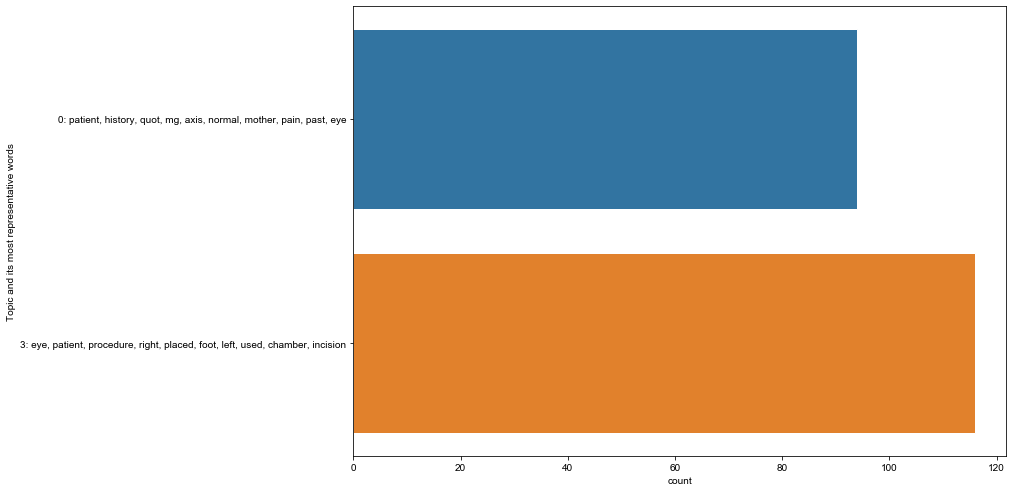

In [16]:
print('Representation of the main topic for each document in the document collection')
tlist = get_topic_list(lda,feature_names, 10)
df_result = display_topic_representation(lda.transform(document_tfidf),df_smaller,tlist)

Does this look reasonable to you? Are all the topics represented? How do you interpret these results?

There's a new column saved in the dataframe that contains the topic number that had the highest probability, we can look at the distribution of those. 

In [17]:
df_result['Topic most represented'].value_counts()

3    116
0     94
Name: Topic most represented, dtype: int64

We can also look at the probability scores each topic resulted in in the whole document collection and get some descriptive statistics. Look at some of the other topics!

In [18]:
df_result['topic1'].describe()

count    210.000000
mean       0.024752
std        0.006295
min        0.014571
25%        0.020402
50%        0.023249
75%        0.028048
max        0.050390
Name: topic1, dtype: float64

Now let's look at the distribution of topics in the files in relation to the 'existing' categories in the dataset. We'll use the function we defined earlier.

For each given file, we calculate the mean percentage of the documents depence to each topic

        Topic  46-ophthalmology  72-psychiatrypsychology  71-podiatry  \
topic0      0          0.228665                 0.936864     0.317478   
topic1      1          0.026098                 0.020765     0.026898   
topic2      2          0.026098                 0.020765     0.026898   
topic3      3          0.719139                 0.021605     0.628726   

        17-dentistry  
topic0      0.205109  
topic1      0.024705  
topic2      0.024705  
topic3      0.745481  
Index(['46-ophthalmology', '72-psychiatrypsychology', '71-podiatry',
       '17-dentistry'],
      dtype='object')


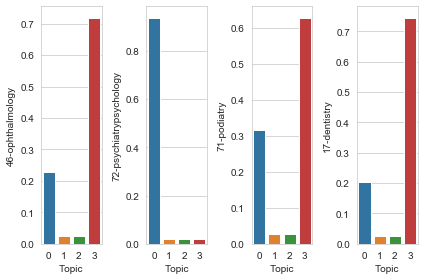

In [19]:
display_file_representation(lda.transform(document_tfidf),df_smaller)

### NMF
Now let's compare with NMF.  

In [20]:
nmf, W, H = getNMFModel(no_topics, document_tfidf)

In [21]:
display_topics(nmf, feature_names, no_top_words)

Topic 0:
eye, chamber, lens, anterior, cataract, right, bag, used, placed, capsular
Topic 1:
patient, history, quot, mg, axis, mother, past, disorder, denies, family
Topic 2:
foot, left, patient, right, ankle, plantar, tendon, metatarsal, lateral, incision
Topic 3:
teeth, tooth, caries, dental, mandible, patient, buccal, ml, throat, left


Representation of the main topic for each document


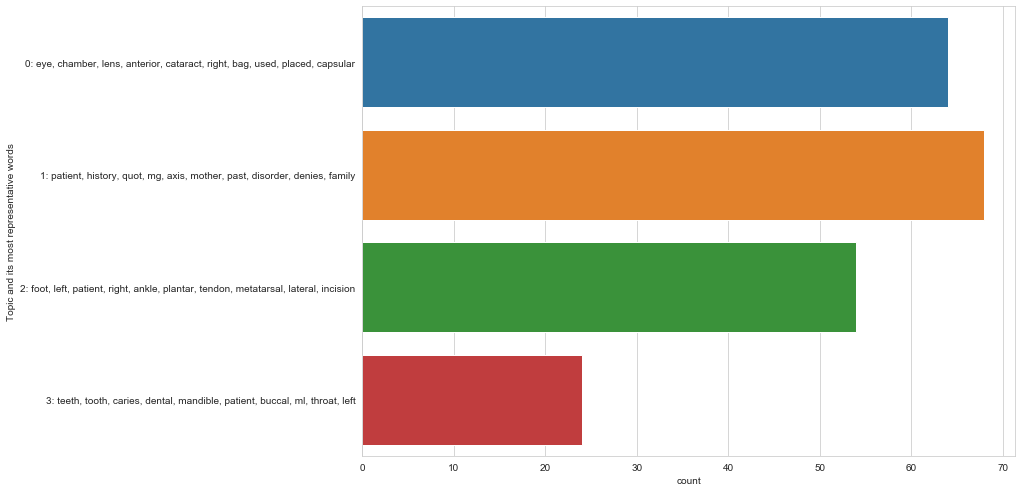

In [22]:
print('Representation of the main topic for each document')

tlist = get_topic_list(nmf,feature_names, 10)
df_result = display_topic_representation(W,df_smaller,tlist)


For each given file, we calculate the mean percentage of the documents depence to each topic

          Topic  46-ophthalmology  72-psychiatrypsychology  71-podiatry  \
topic0_x      0          0.217147                 0.000103     0.003959   
topic1_x      1          0.024771                 0.304825     0.033483   
topic2_x      2          0.025931                 0.000444     0.278998   
topic3_x      3          0.007534                 0.000000     0.003497   

          17-dentistry  
topic0_x      0.009361  
topic1_x      0.043000  
topic2_x      0.029675  
topic3_x      0.349090  
Index(['46-ophthalmology', '72-psychiatrypsychology', '71-podiatry',
       '17-dentistry'],
      dtype='object')


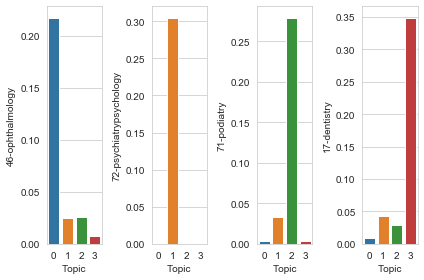

In [23]:
display_file_representation(W,df_result)

## LDA vs NMF?
What do you think about these results and models? What main differences do you notice when comparing NMF and LDA results? Do you think one is better than the other? What parameters might be worth changing?

# Choosing number of topics ('k') - coherence score

There are several metrics proposed for automatically calculating what the 'optimal' number of topics in a document collection is, by trying to measure how coherent generated topics are.

Here, we will use the TC-W2W score proposed by O'Callaghan et al. 

O’Callaghan, D., Greene, D., Carthy, J., & Cunningham, P. (2015). 
An analysis of the coherence of descriptors in topic modeling. 
Expert Systems with Applications, 42(13), 5645-5657

The code is from: https://github.com/derekgreene/topic-model-tutorial/blob/master/3%20-%20Parameter%20Selection%20for%20NMF.ipynb
With slight adaptations for our example.

The main idea with this score is to calculate the pairwise embedding vector similarity for each term pair in the top ranked words in each generated topic.

We need to have a word2vec model first. We'll start by building one on the entire document collection we have. NOTE: this means that we have an 'in-domain' model.

In [24]:
import gensim

w2v_model = gensim.models.Word2Vec(df['Document words'], size=300, min_count=2, batch_words=1000)


How big is the vocabulary in this embedding model? 

In [25]:
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 44645 terms


Recap: we can get similarity scores for different word pairs in these types of models. We can try this on a pair of words from the generated topics in our previous NMF model, e.g. topic3 had the words 'teeth' and 'tooth'

In [26]:
w2v_model.similarity('teeth', 'tooth')

0.5011167

Next, we need to build topic models with different number of topics assigned. Let's define a range of k to try.

In [27]:
kmin, kmax = 3, 15

Let's try our smaller dataset again, and generate a tfidf-representation to use in the topic models.

In [28]:
feature_names, document_tfidf = get_tfidf_model(df_smaller, 'Document Content')

Now, let's generate NMF topic models for each value of k in our range

In [29]:
from sklearn import decomposition
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    #model = decomposition.NMF( init="nndsvd", n_components=k ) 
    model = decomposition.NMF( n_components=k, 
          random_state=1, 
          alpha=.1, 
          l1_ratio=.5, 
          init='nndsvd') 
    W = model.fit_transform( document_tfidf )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying NMF for k=3 ...
Applying NMF for k=4 ...
Applying NMF for k=5 ...
Applying NMF for k=6 ...
Applying NMF for k=7 ...
Applying NMF for k=8 ...
Applying NMF for k=9 ...
Applying NMF for k=10 ...
Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...


We need a couple of functions to calculate the coherence score

In [30]:
from itertools import combinations
def calculate_coherence( w2v_model, term_rankings , print_pairs=False):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            ## check if word in vocabulary first!! Added by Sumithra
            if pair[0] in w2v_model.wv.vocab and pair[1] in w2v_model.wv.vocab:
                pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
                if print_pairs:
                    print(pair[0], pair[1], w2v_model.similarity(pair[0], pair[1]))
            else:
                if print_pairs:
                    print('word pair not in vocabulary', pair[0], pair[1])
                pair_scores.append( 0.0 )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [31]:
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

Let's calculate the coherence score for each model with k topics.

In [32]:

k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( feature_names, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings, print_pairs=False ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=03: Coherence=0.2419
K=04: Coherence=0.2492
K=05: Coherence=0.2215
K=06: Coherence=0.2437
K=07: Coherence=0.2735
K=08: Coherence=0.2785
K=09: Coherence=0.2571
K=10: Coherence=0.2592
K=11: Coherence=0.2518
K=12: Coherence=0.2412
K=13: Coherence=0.2551
K=14: Coherence=0.2564
K=15: Coherence=0.2627


We can plot this to visualise

In [33]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

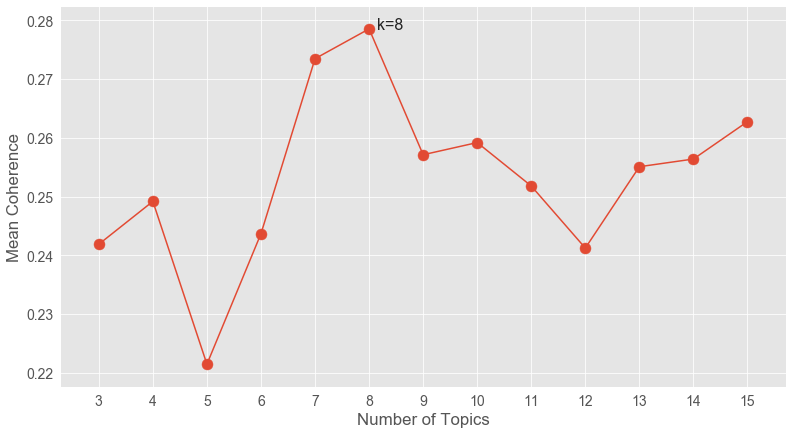

In [34]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

What seems to be the 'optimal' number of topics? Does this make sense do you think?

Now let's build a model with this 'k' and look at what the model produces

In [35]:

## Assign a value to no_topics from the results above
no_topics = 8 # fill in here

## How many words do you want as topic descriptors?
no_top_words = 10 # fill in here

In [36]:
nmf, W, H = getNMFModel(no_topics, document_tfidf)

Representation of the main topic for each document


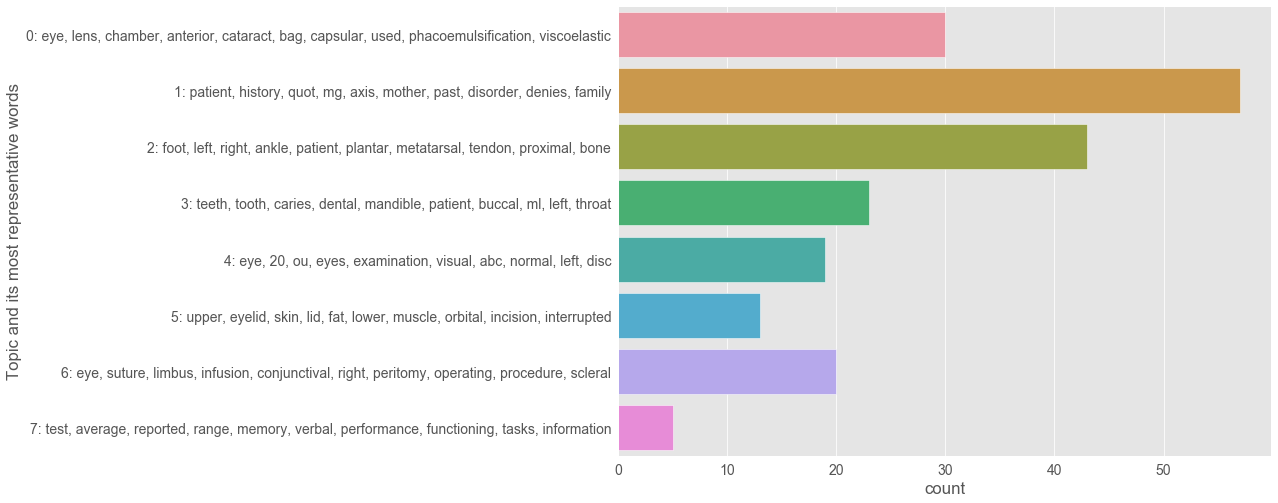

In [37]:
print('Representation of the main topic for each document')

tlist = get_topic_list(nmf,feature_names, 10)
df_result = display_topic_representation(W,df_smaller,tlist)

In [38]:
df_result.head()

,Unnamed: 0,index,Category,Document Name,Document Content,Document words,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,Topic most represented,Topic and its most representative words
129,5386,129,46-ophthalmology,2386-phacoemulsificationlensimplantation-5.txt,PREOPERATIVE D...,"[preoperative, diagnosis, , cataract, , right,...",0.373079,0.000000,0.000000,0.0,0.000000,0.0,0.077006,0.0,0,"0: eye, lens, chamber, anterior, cataract, bag..."
92,5349,92,46-ophthalmology,1964-phacoemulsificationlensimplantation-2.txt,PROCEDURE PERF...,"[procedure, performed, , phacoemulsification, ...",0.471224,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0,"0: eye, lens, chamber, anterior, cataract, bag..."
93,5350,93,46-ophthalmology,1958-cataractextraction.txt,PROCEDURE PERF...,"[procedure, performed, , cataract, extraction,...",0.322384,0.000000,0.011183,0.0,0.000000,0.0,0.061070,0.0,0,"0: eye, lens, chamber, anterior, cataract, bag..."
84,5341,84,46-ophthalmology,1966-yaglasercapsulotomy-1.txt,PREOPERATIVE D...,"[preoperative, diagnosis, , secondary, capsula...",0.199040,0.020780,0.005793,0.0,0.045491,0.0,0.003762,0.0,0,"0: eye, lens, chamber, anterior, cataract, bag..."
83,5340,83,46-ophthalmology,1896-yaglasercapsulotomy.txt,PREOPERATIVE D...,"[preoperative, diagnosis, , visually, signific...",0.167168,0.038911,0.026814,0.0,0.063760,0.0,0.031371,0.0,0,"0: eye, lens, chamber, anterior, cataract, bag..."


In [39]:
#We can also look at the distribution of topics per document.
# We can extract the columns with topic probabilities

tmp = df_result[['index', 'topic0', 'topic1', 'topic2', 'topic3', 'topic4',
       'topic5', 'topic6', 'topic7']]

## Let's sample a few documents
tmp = tmp.sample(5)

Let's plot these

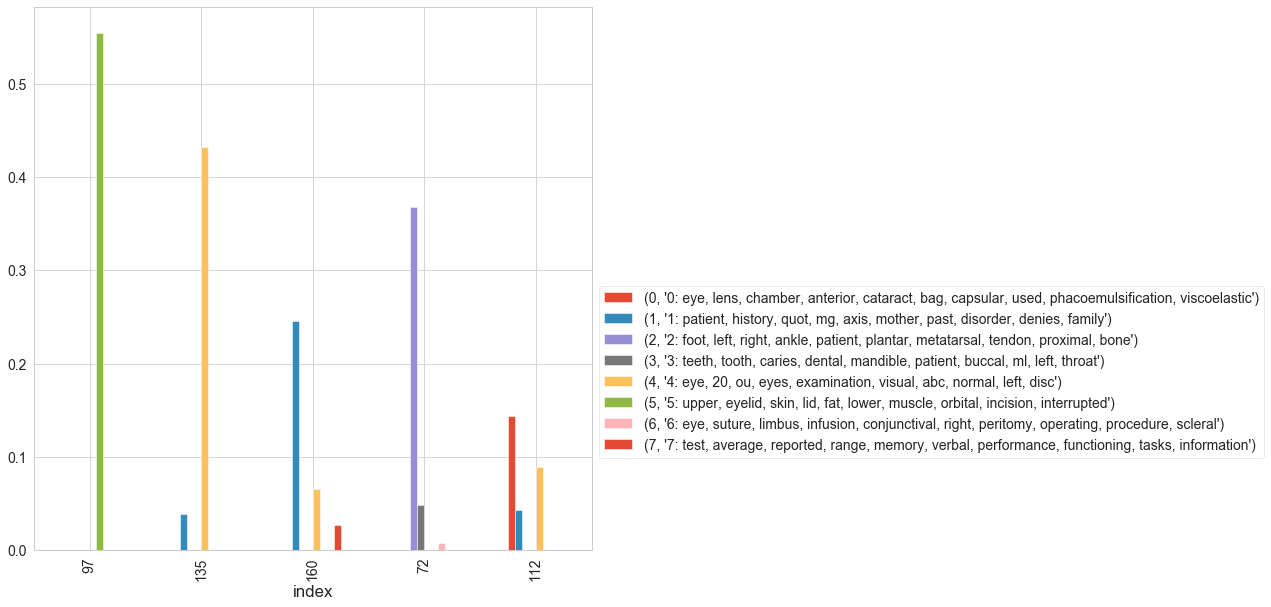

In [40]:
ax = tmp.plot.bar(figsize=(10,10), x='index')
ax.legend(tlist.items(), bbox_to_anchor=(1, 0.5));

Let's look at one of these documents

In [43]:
tmp[tmp['index']==112]

,index,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7
112,112,0.143491,0.043589,0.0,0.0,0.089761,0.0,0.0,0.0


In [46]:
df_smaller[df_smaller['index']==112]['Document Content'].tolist()

['                                CATARACT is the loss of transparency of the lens of the eye.  It often appears like a window that is fogged with steam.WHAT CAUSES CATARACT FORMATION?*  Aging, the most common cause.*  Family history.*  Steroid use.*  Injury to the eye.*  Diabetes.*  Previous eye surgery.*  Long-term exposure to sunlight.HOW DO I KNOW IF I HAVE A CATARACT?*  The best way for early detection is regular eye examinations by your medical eye doctor. There are many causes of visual loss in addition to the cataract such as problems involving the optic nerve and retina.  If these other problems exist, cataract removal may not result in the return or improvement of vision.  Your eye doctor can tell you how much improvement in vision is likely.DOES IT TAKE A LONG TIME FOR A CATARACT TO FORM?Cataract development varies greatly between patients and is affected by the cause of the cataract.  Generally, cataracts progress gradually over many years.  Some people, especially diabetic

In [47]:
tmp[tmp['index']==72]

,index,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7
72,72,0.0,0.0,0.367475,0.048745,0.0,0.0,0.008027,0.0


In [48]:
df_smaller[df_smaller['index']==72]['Document Content'].tolist()

["                                PREOPERATIVE DIAGNOSIS:  Morton's neuroma, third interspace, left foot.POSTOPERATIVE DIAGNOSIS:  Morton's neuroma, third interspace, left foot.OPERATION PERFORMED:  Excision of neuroma, third interspace, left foot.ANESTHESIA:  General (local was confirmed by surgeon).HEMOSTASIS:  Ankle pneumatic tourniquet 225 mmHg.TOURNIQUET TIME:  18 minutes.  Electrocautery was necessary.INJECTABLES:  50:50 mixture of 0.5% Marcaine and 1% Xylocaine, both plain.  Also, 0.5 mL dexamethasone phosphate (4 mg/mL).INDICATIONS:  Please see dictated H&P for specifics.PROCEDURE:  After proper identification was made, the patient was brought to the operating room and placed on the table in supine position.  The patient was then placed under general anesthesia.  A local block was then injected into the third ray of the left foot.  The left foot was then prepped with chlorhexidine gluconate and then draped in the usual sterile technique.  The left foot was then exsanguinated wi

In [49]:
df_smaller[df_smaller['index']==72]

,Unnamed: 0,index,Category,Document Name,Document Content,Document words
4862,4862,72,71-podiatry,2481-neuromaexcision.txt,PREOPERATIVE D...,"[preoperative, diagnosis, , morton, s, neuroma..."
